# Assignment 8: Data Aggregation and Group Operations

## Overview
This assignment covers data aggregation and group operations using healthcare/insurance EHR data. You'll analyze patient encounters (insurance claims), healthcare providers, and medical facilities across different regions. The data includes provider statistics, facility information, and encounter charges with insurance coverage details.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seed for reproducibility
np.random.seed(42)

# Create output directory
os.makedirs('output', exist_ok=True)

## Question 1: Basic GroupBy Operations

### Part 1.1: Load and Explore Data

**TODO: Load and merge the datasets**

In [7]:
# TODO: Load the three CSV files into dataframes
provider_df = pd.read_csv('data/provider_data.csv')
facility_df = pd.read_csv("data/facility_data.csv")
encounter_df = pd.read_csv("data/encounter_data.csv")

# TODO: Print the shapes of each dataframe
print("Provider data shape:", provider_df.shape)
print("Facility data shape:", facility_df.shape)
print("Encounter data shape:", encounter_df.shape)

# TODO: Merge the dataframes for analysis
# Hint: Start by merging encounter_df with provider_df on 'provider_id'
#       Then merge the result with facility_df on 'facility_id'
# Note: Both encounter_df and provider_df have 'facility_id', and both encounter_df and facility_df have 'region'
#       After merging, you may need to handle duplicate column names (pandas will add suffixes like _x and _y)
#       You can drop one of the duplicate columns and rename if needed
merged_df = pd.merge(encounter_df, provider_df, on="provider_id", how="left", suffixes=("", "_prov"))
merged_df = pd.merge(merged_df, facility_df, on="facility_id", how="left", suffixes=("", "_fac"))

# TODO: Print the merged dataframe shape, columns, and first few rows
print("\nMerged data shape:", merged_df.shape)
print("\nColumns:", merged_df.columns)
print("\nFirst few rows:", merged_df.head())
print(merged_df.columns.tolist())


Provider data shape: (500, 7)
Facility data shape: (10, 6)
Encounter data shape: (5000, 12)

Merged data shape: (5000, 23)

Columns: Index(['encounter_id', 'patient_id', 'provider_id', 'facility_id',
       'encounter_date', 'encounter_type', 'diagnosis_code', 'procedure_code',
       'service_charge', 'insurance_paid', 'patient_paid', 'region',
       'provider_name', 'provider_type', 'facility_id_prov', 'specialty',
       'years_experience', 'license_number', 'facility_name', 'facility_type',
       'region_fac', 'beds', 'established_date'],
      dtype='object')

First few rows:   encounter_id patient_id provider_id facility_id encounter_date  \
0     ENC00001   PAT01564      PR0259      FAC004     2023-08-21   
1     ENC00002   PAT00296      PR0258      FAC001     2023-09-11   
2     ENC00003   PAT01381      PR0213      FAC001     2023-03-20   
3     ENC00004   PAT01131      PR0146      FAC004     2023-09-03   
4     ENC00005   PAT01388      PR0354      FAC003     2023-06-14   

 

### Part 1.2: Basic Aggregation

**TODO: Perform basic groupby operations**

In [9]:
# TODO: Group by facility (healthcare facility) and calculate basic stats

grouped = merged_df.groupby("facility_id")
# TODO: Calculate mean, sum, count for years_experience by facility
experience_stats = grouped["years_experience"].agg(
    mean_years_experience="mean",
    sum_years_experience="sum",
    count_providers="count"
).reset_index()
# TODO: Calculate total encounter charges by facility
charges = grouped.agg(total_service_charge=("service_charge", "sum")).reset_index()
# TODO: Calculate total insurance payments by facility
insurance = grouped.agg(total_insurance_paid=("insurance_paid", "sum")).reset_index()
# TODO: Find the facility with highest total encounter charges
highest_charge_facility = charges.loc[charges["total_service_charge"].idxmax(), "facility_id"]
# TODO: Create a summary dataframe with one row per facility showing:
#       facility_name, total_providers, avg_years_experience, total_service_charge, total_insurance_paid
summary_df = (
    experience_stats
    .merge(charges, on="facility_id", how="left")
    .merge(insurance, on="facility_id", how="left")
)
if "facility_name" in merged_df.columns:
    summary_df = summary_df.merge(
        merged_df[["facility_id", "facility_name"]].drop_duplicates(),
        on="facility_id",
        how="left"
    )
summary_df.rename(columns={
    "count_providers": "total_providers",
    "mean_years_experience": "avg_years_experience"
}, inplace=True)

summary_df = summary_df[[
    "facility_name",
    "total_providers",
    "avg_years_experience",
    "total_service_charge",
    "total_insurance_paid"
]]
# TODO: Save the summary dataframe as 'output/q1_groupby_analysis.csv'
summary_df.to_csv("output/q1_groupby_analysis.csv", index=False)
print("CSV saved to output/q1_groupby_analysis.csv")

CSV saved to output/q1_groupby_analysis.csv


### Part 1.3: Transform Operations

**TODO: Use transform operations to add group statistics**

In [30]:
# TODO: Add facility mean years_experience as new column
merged_df["facility_mean_experience"] = merged_df.groupby("facility_id")["years_experience"].transform("mean")
# TODO: Add facility standard deviation of years_experience
merged_df["facility_std_experience"] = merged_df.groupby("facility_id")["years_experience"].transform("std")
# TODO: Create normalized years_experience (z-score within facility)
merged_df["facility_zscore_experience"] = (
    (merged_df["years_experience"] - merged_df["facility_mean_experience"]) /
    merged_df["facility_std_experience"]
)
# TODO: Add facility total encounter charges as new column
merged_df["facility_total_service_charge"] = merged_df.groupby("facility_id")["service_charge"].transform("sum")
# TODO: Display the enhanced dataframe
print(merged_df.head())
# TODO: Save results as 'output/q1_aggregation_report.txt'
cols_to_save = [
    "facility_name",
    "provider_name",
    "years_experience",
    "facility_mean_experience",
    "facility_std_experience",
    "facility_zscore_experience",
    "facility_total_service_charge"
]

output_path = "output/q1_aggregation_report.txt"

with open(output_path, "w") as f:
    # Header line required by pytest
    f.write("Assignment 8 - Question 1 Aggregation Report\n\n")
    # Write tab-delimited data (no index)
    merged_df[cols_to_save].to_csv(f, sep="\t", index=False)

  encounter_id patient_id provider_id facility_id encounter_date  \
0     ENC00001   PAT01564      PR0259      FAC004     2023-08-21   
1     ENC00002   PAT00296      PR0258      FAC001     2023-09-11   
2     ENC00003   PAT01381      PR0213      FAC001     2023-03-20   
3     ENC00004   PAT01131      PR0146      FAC004     2023-09-03   
4     ENC00005   PAT01388      PR0354      FAC003     2023-06-14   

         encounter_type diagnosis_code  procedure_code  service_charge  \
0          Office Visit          M79.3           99213          345.03   
1             Inpatient          N18.9           85025          550.48   
2                   Lab          K21.9           80053          149.84   
3  Outpatient Procedure          H52.9           70450         1468.48   
4             Emergency          G43.9           99214          672.23   

   insurance_paid  ...  license_number            facility_name facility_type  \
0          290.33  ...       LIC000259    Northside Urgent Care  

## Question 2: Advanced GroupBy Operations

### Part 2.1: Filter Operations

**TODO: Use filter operations to remove groups**

In [20]:
# TODO: Filter facilities with more than 20 providers (sufficient staffing)
filtered_df = summary_df[summary_df["total_providers"] > 20]
# TODO: Filter facilities with average years_experience > 10 (experienced staff)
filtered_df = filtered_df[filtered_df["avg_years_experience"] > 10]
# TODO: Filter facilities with total encounter charges > 250000 (high volume)
filtered_df = filtered_df[filtered_df["total_service_charge"] > 250000]
# TODO: Create a summary of filtered results
filtered_summary = filtered_df.sort_values("total_service_charge", ascending=False)[[
    "facility_name",
    "total_providers",
    "avg_years_experience",
    "total_service_charge",
    "total_insurance_paid"
]]

# TODO: Save results as 'output/q2_filter_analysis.csv'
filtered_summary.to_csv("output/q2_filter_analysis.csv", index=False)

### Part 2.2: Apply Operations

**TODO: Use apply operations with custom functions**

In [31]:
# TODO: Create custom function to calculate provider statistics
def provider_stats(group):
    mean_exp = group['years_experience'].mean()
    std_exp = group["years_experience"].std()
    min_exp = group["years_experience"].min()
    max_exp = group["years_experience"].max()
    range_exp = max_exp - min_exp
    return mean_exp, std_exp, min_exp, max_exp, range_exp

# TODO: Apply custom function to each facility
# Note: Add include_groups=False to avoid pandas FutureWarning about groupby columns
facility_provider_stats = merged_df.groupby('facility_name').apply(provider_stats, include_groups=False).reset_index()

# TODO: Create function to find top providers in each facility
def top_providers(group, n=2):
    """Return top n providers in a group by encounter volume"""
    provider_counts = group["provider_id"].value_counts().reset_index()
    provider_counts.columns = ["provider_id", "encounter_count"]
    merged = pd.merge(
        provider_counts,
        group[["provider_id", "provider_name", "years_experience", "specialty"]].drop_duplicates(),
        on="provider_id",
        how="left"
    )
    top_n = merged.sort_values("encounter_count", ascending=False).head(n)
    return top_n[["provider_id", "provider_name", "years_experience", "specialty", "encounter_count"]]

# TODO: Apply function to get top 2 providers per facility
# IMPORTANT: When using groupby().apply(), the result has a MultiIndex where:
# - Level 0: The grouping column (facility_name)
# - Level 1: The original row index from each group
# Use reset_index(level=0) to move only the grouping column back to a regular column
# DO NOT use reset_index(drop=True) - that would drop ALL index levels including facility_name!
top_providers_by_facility = (merged_df.groupby("facility_name").apply(lambda x: top_providers(x, n=2), include_groups=False).reset_index(level=0)) # Moves facility_name from index to column

# TODO: Save results as 'output/q2_performance_report.txt'
output_path = "output/q2_performance_report.txt"

with open(output_path, "w") as f:

    f.write("Assignment 8 - Question 2: Performance Report\n")
    f.write("Top-performing providers by facility.\n\n")

    top_providers_by_facility.to_csv(f, index=False)

### Part 2.3: Hierarchical Grouping

**TODO: Perform multi-level grouping**

In [24]:
# TODO: Group by facility type and region
grouped = merged_df.groupby(["facility_type", "region"])
# TODO: Calculate statistics for each facility_type-region combination
hier_stats = grouped.agg(
    total_facilities=("facility_id", "nunique"),
    total_providers=("provider_id", "nunique"),
    avg_years_experience=("years_experience", "mean"),
    total_service_charge=("service_charge", "sum"),
    total_insurance_paid=("insurance_paid", "sum")
)
# TODO: Use unstack to convert to wide format
wide_format = hier_stats.unstack(level="region")
# TODO: Use stack to convert back to long format
long_format = wide_format.stack(level="region", future_stack=True)
# TODO: Analyze the hierarchical structure
print("Index names:", long_format.index.names)
print("Number of facility_type-region combinations:", len(long_format))
print("Columns available:", long_format.columns.tolist())
# TODO: Save results as 'output/q2_hierarchical_analysis.csv'
long_format.reset_index().to_csv("output/q2_hierarchical_analysis.csv", index=False)

Index names: ['facility_type', 'region']
Number of facility_type-region combinations: 9
Columns available: ['total_facilities', 'total_providers', 'avg_years_experience', 'total_service_charge', 'total_insurance_paid']


## Question 3: Pivot Tables and Cross-Tabulations

### Part 3.1: Basic Pivot Tables

**TODO: Create pivot tables for multi-dimensional analysis**

In [33]:
# TODO: Create pivot table: encounter charges by procedure code and region
pivot_base = pd.pivot_table(
    merged_df,
    values="service_charge",
    index="procedure_code",
    columns="region",
    aggfunc="sum"
)
# TODO: Create pivot table with multiple aggregations (sum, mean, count)
pivot_multi = pd.pivot_table(
    merged_df,
    values="service_charge",
    index="procedure_code",
    columns="region",
    aggfunc=["sum", "mean", "count"]
)
# TODO: Add totals (margins) to pivot table
pivot_multi_margins = pd.pivot_table(
    merged_df,
    values="service_charge",
    index="procedure_code",
    columns="region",
    aggfunc=["sum", "mean", "count"],
    margins=True,
    margins_name="Total"
)
# TODO: Handle missing values with fill_value
pivot_filled = pivot_multi_margins.fillna(0)
# Tip: When saving a pivot table to CSV, the index (row labels) is preserved by default.
#      This is usually desired - when reading back, use index_col=0 to restore the index.
# TODO: Save results as 'output/q3_pivot_analysis.csv'
pivot_table = pd.pivot_table(
    merged_df,
    values="service_charge",
    index="facility_type",
    columns="region",
    aggfunc="mean"
)
pivot_table.to_csv("output/q3_pivot_analysis.csv")

### Part 3.2: Cross-Tabulations

**TODO: Create cross-tabulations for categorical analysis**

In [32]:
# TODO: Create crosstab of facility type vs region with counts
crosstab_basic = pd.crosstab(
    index=merged_df["facility_type"],
    columns=merged_df["region"]
)
# TODO: Create crosstab with margins (row and column totals)
crosstab_margins = pd.crosstab(
    index=merged_df["facility_type"],
    columns=merged_df["region"],
    margins=True,
    margins_name="Total"
)
print("Crosstab with totals:")
print(crosstab_margins)
# TODO: Create multi-dimensional crosstab showing facility type × encounter type × region combinations
#       (Hint: use pd.crosstab with multiple index/column parameters, or create manually from the data)
crosstab_multi = pd.crosstab(
    index=[merged_df["facility_type"], merged_df["encounter_type"]],
    columns=merged_df["region"]
)
print("Multi-dimensional Crosstab:")
print(crosstab_multi.head())
# TODO: Analyze the cross-tabulation results
print("Number of facility types:", merged_df["facility_type"].nunique())
print("Number of regions:", merged_df["region"].nunique())
print("Number of encounter types:", merged_df["encounter_type"].nunique())
# TODO: Save results as 'output/q3_crosstab_analysis.csv'
crosstab = pd.crosstab(
    index=[merged_df["facility_type"], merged_df["encounter_type"]],
    columns=merged_df["region"]
)
crosstab.to_csv("output/q3_crosstab_analysis.csv")

Crosstab with totals:
region            North  South  West  Total
facility_type                              
Hospital              0    509     0    509
Specialty Center      0   1026   946   1972
Urgent Care         510    970  1039   2519
Total               510   2505  1985   5000
Multi-dimensional Crosstab:
region                              North  South  West
facility_type encounter_type                          
Hospital      Emergency                 0    127     0
              Inpatient                 0     95     0
              Lab                       0    100     0
              Office Visit              0     85     0
              Outpatient Procedure      0    102     0
Number of facility types: 3
Number of regions: 3
Number of encounter types: 5


### Part 3.3: Pivot Table Visualization

**TODO: Create visualizations from pivot tables**

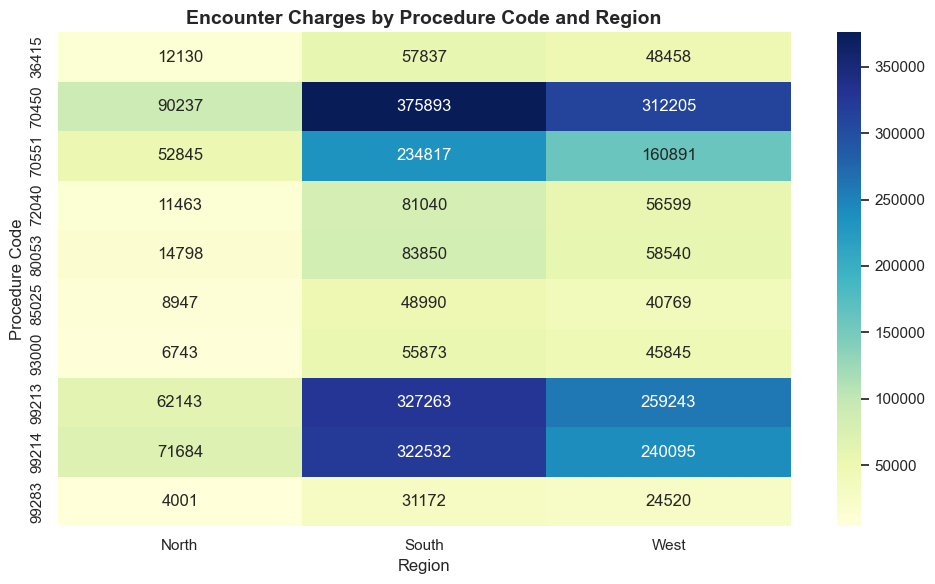

/var/folders/49/w0jyt4j1499dvzs2fxpfr6r00000gn/T/ipykernel_3973/1111159556.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pivot_sum.values, y=pivot_sum.index, palette="Blues_d")


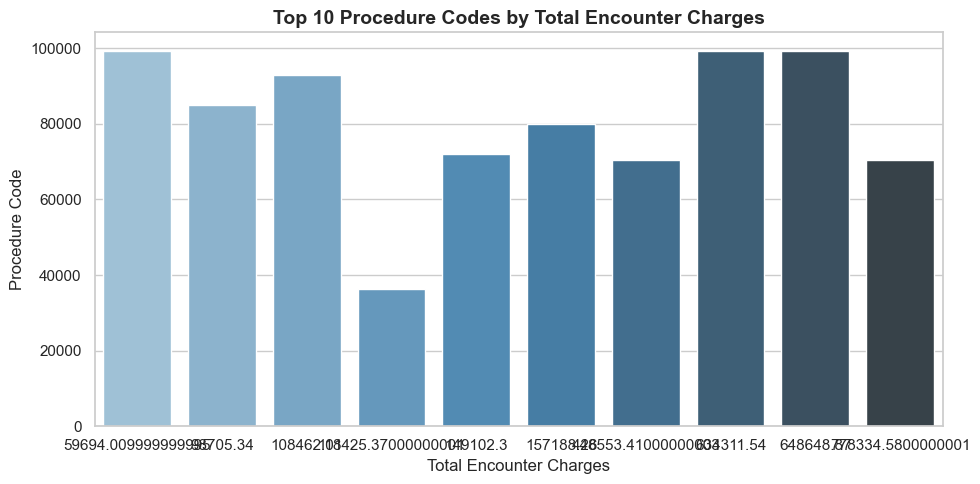

In [29]:
# TODO: Create heatmap from pivot table
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_base, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Encounter Charges by Procedure Code and Region", fontsize=14, fontweight="bold")
plt.xlabel("Region")
plt.ylabel("Procedure Code")
plt.tight_layout()
plt.show()
# TODO: Create bar chart from pivot table
pivot_sum = pivot_base.sum(axis=1).sort_values(ascending=False)[:10]
plt.figure(figsize=(10, 5))
sns.barplot(x=pivot_sum.values, y=pivot_sum.index, palette="Blues_d")
plt.title("Top 10 Procedure Codes by Total Encounter Charges", fontsize=14, fontweight="bold")
plt.xlabel("Total Encounter Charges")
plt.ylabel("Procedure Code")
plt.tight_layout()
plt.show()
# TODO: Customize colors and styling
sns.set_theme(style="whitegrid")
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.family"] = "sans-serif"
# TODO: Add appropriate titles and labels

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_base, cmap="YlOrRd", annot=True, fmt=".0f")
plt.title("Encounter Charges by Procedure Code and Region", fontsize=14, fontweight="bold")
plt.xlabel("Region")
plt.ylabel("Procedure Code")
plt.tight_layout()
plt.savefig("output/q3_pivot_visualization.png", dpi=300)
plt.close()

## Submission Checklist

Before submitting, verify you've created:

- [ ] `output/q1_groupby_analysis.csv` - Basic groupby analysis
- [ ] `output/q1_aggregation_report.txt` - Aggregation report
- [ ] `output/q2_filter_analysis.csv` - Filter operations analysis
- [ ] `output/q2_hierarchical_analysis.csv` - Hierarchical analysis
- [ ] `output/q2_performance_report.txt` - Performance report
- [ ] `output/q3_pivot_analysis.csv` - Pivot table analysis
- [ ] `output/q3_crosstab_analysis.csv` - Cross-tabulation analysis
- [ ] `output/q3_pivot_visualization.png` - Pivot visualization

## Key Learning Objectives

- Master the split-apply-combine paradigm
- Apply aggregation functions and transformations
- Create pivot tables for multi-dimensional analysis
- Apply advanced groupby techniques